# Import data

In [1]:
!pip install matplotlib
!pip install sklearn
!pip install imblearn
!pip install scipy
!pip install seaborn

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from scipy import stats
import seaborn as sns
import numpy as np

In [4]:
import pandas as pd
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Data Analysis

In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


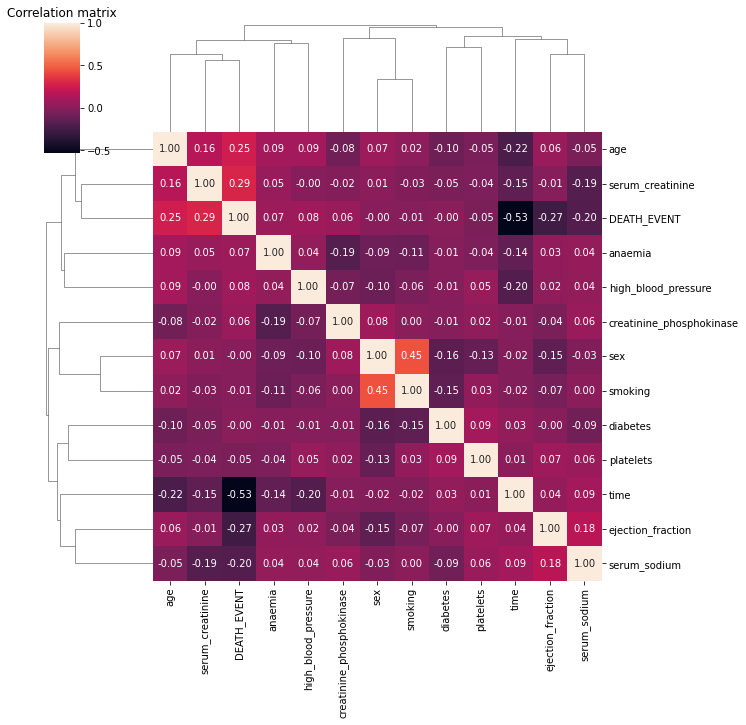

In [6]:
# Create a correlation matrix
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation matrix")
plt.show()

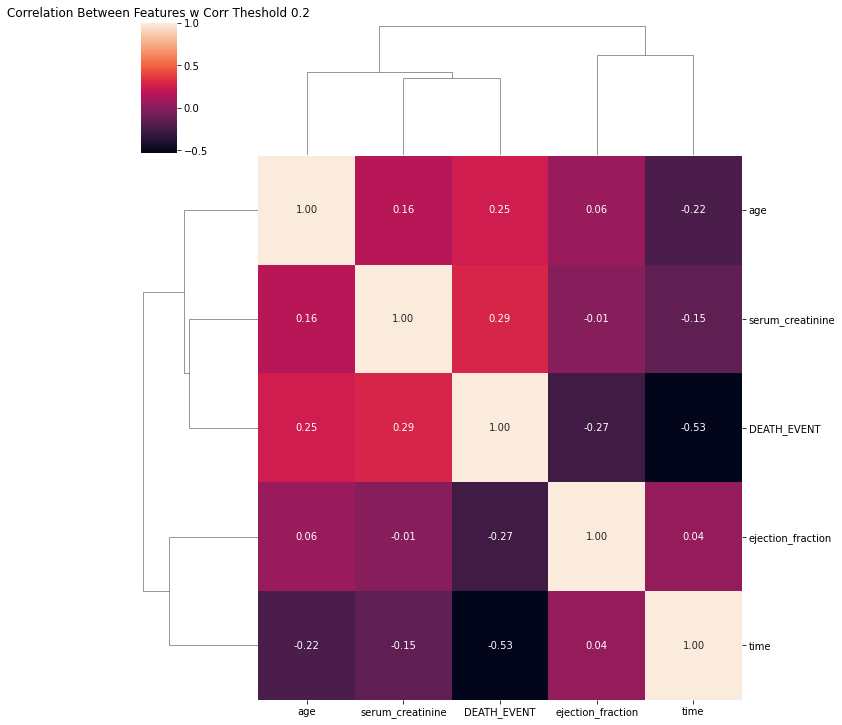

In [7]:
# Add threshold to find highest correlations
threshold = 0.2 
filtr = np.abs(corr_matrix['DEATH_EVENT']) > threshold

# Select thresholded features
corr_features = corr_matrix.columns[filtr].tolist()

# Visualize
sns.clustermap(df[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.2")
plt.show()

<AxesSubplot:>

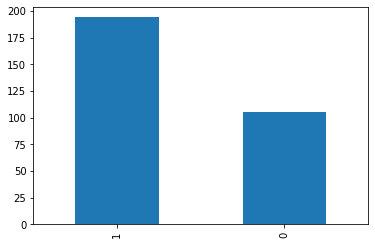

In [8]:
val = df['sex'].value_counts()
val.plot.bar()

Labels: 1 = male, 0 = female.   
Analysis of the dataset shows that there is an overrepresentation of men in the dataset. This imbalance needs to be taken into account. Given that we have a limited datset here, we would like to avoid removing any records.

<AxesSubplot:>

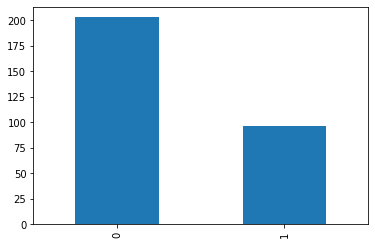

In [9]:
death = df['DEATH_EVENT'].value_counts()
death.plot.bar()

Labels: 1 = death, 0 = no death.   
Analysis of the dataset shows that the target label is also skewed. This should be taken into account as well.

## Lets check and remove outliers

In [10]:
from collections import Counter
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1) 
    
    return multiple_outliers

In [11]:
data = df.drop(detect_outliers(df,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]),axis = 0).reset_index(drop=True)

## Check and find skewed variables

In [12]:
from scipy.stats import norm, skew, boxcox
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
creatinine_phosphokinase,4.827396
serum_creatinine,4.605615
platelets,1.429547
DEATH_EVENT,0.797132
smoking,0.729243
high_blood_pressure,0.583959
ejection_fraction,0.546146
age,0.413840
diabetes,0.358569
anaemia,0.286636


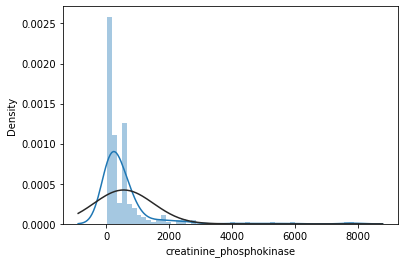

mu creatinine_phosphokinase : 553.121107266436,
sigma creatinine_phosphokinase : 943.411428667967


In [13]:
# creatinine_phosphokinase
sns.distplot(data["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["creatinine_phosphokinase"])
print("mu {} : {},\nsigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))

In [14]:
data["creatinine_phosphokinase"], lam = boxcox(data["creatinine_phosphokinase"])

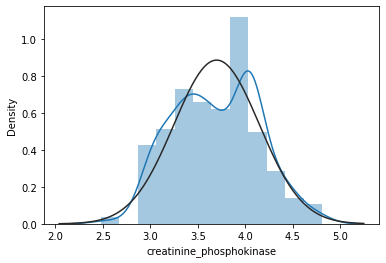

mu creatinine_phosphokinase : 3.698843171315633,
sigma creatinine_phosphokinase : 0.4504255141000855


In [15]:
# creatinine_phosphokinase
sns.distplot(data["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["creatinine_phosphokinase"])
print("mu {} : {},\nsigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))

In [16]:
# Save copy of current distribution for later viz
pre1 = data["serum_creatinine"].copy()
pre2 = data["ejection_fraction"].copy()
pre3 = data["platelets"].copy()

In [18]:
# We do the same for the other skewed values
data["serum_creatinine"], lam_serum_creatine = boxcox(data["serum_creatinine"])
data["ejection_fraction"], lam_serum_creatine = boxcox(data["ejection_fraction"])
data["platelets"], lam_serum_creatine = boxcox(data["platelets"])

<AxesSubplot:xlabel='platelets', ylabel='Density'>

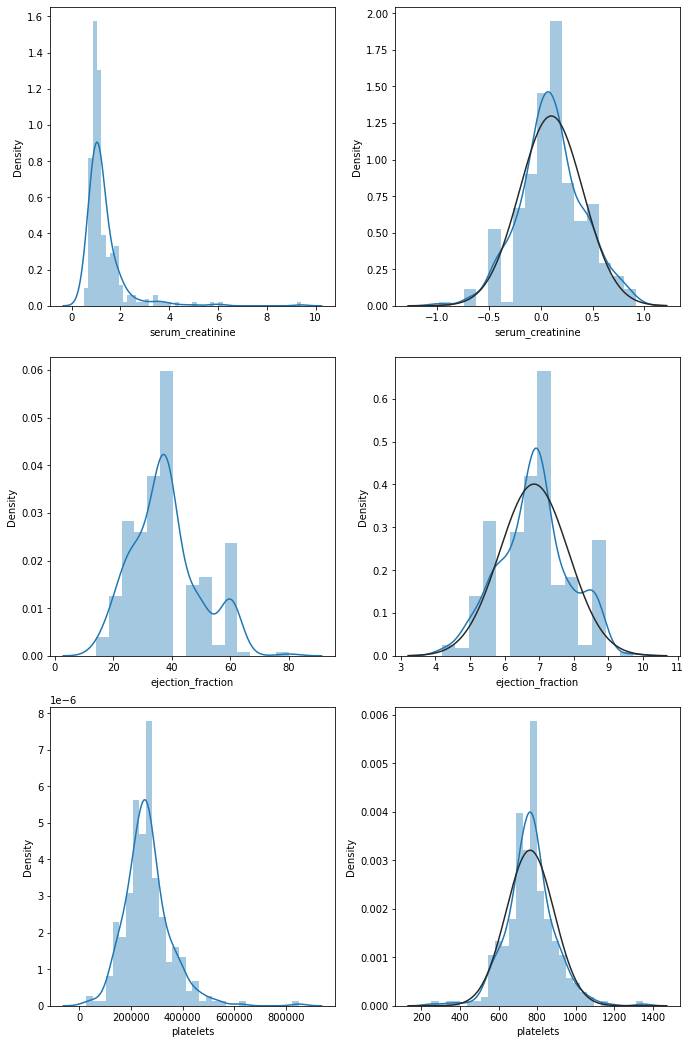

In [19]:
fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(10,15))
fig.tight_layout(pad=3.0)
sns.distplot(pre1,ax=axs[0,0])
sns.distplot(data["serum_creatinine"],fit=norm, ax=axs[0,1])
sns.distplot(pre2,ax=axs[1,0])
sns.distplot(data["ejection_fraction"], fit=norm,ax=axs[1,1])
sns.distplot(pre3, ax=axs[2,0])
sns.distplot(data["platelets"], fit=norm, ax=axs[2,1])

# Ensemble approach

## Try Random Forest

In [20]:
data = df.iloc[:,:-1]
target = df.iloc[:,-1]

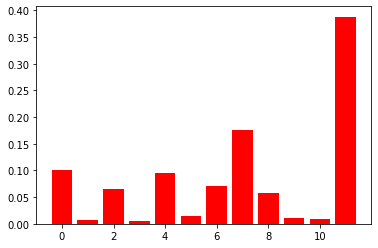

In [21]:
# model: Random forest
model = RandomForestClassifier(n_estimators=10, class_weight='balanced')
model.fit(data,target)
importance = model.feature_importances_

plt.bar([x for x in range(len(importance))], importance, color = "red")
plt.show()



In [22]:
subs = data.iloc[:,[0,2,4,6,8,11]]

In [23]:

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate
scores = cross_val_score(model, subs, target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.874


## expand Random Forest with Bootstrap

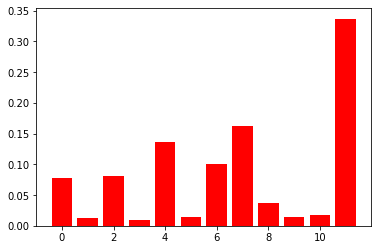

In [24]:
# define model
model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
model.fit(data,target)

importance = model.feature_importances_

plt.bar([x for x in range(len(importance))], importance, color = "red")
plt.show()



In [25]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, data, target, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.888


In [26]:
subs1 = data.iloc[:,[0,2,4,6,8,11]]
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, subs1, target, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.879


## RF with random undersampling

In [27]:
# model: Random forest
model = BalancedRandomForestClassifier(n_estimators=10)
model.fit(data,target)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate
scores = cross_val_score(model, data, target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.881


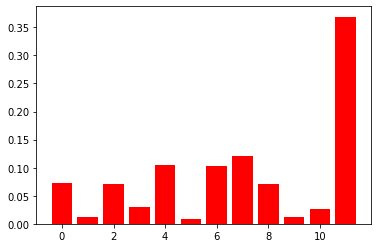

In [28]:
# model: Random forest
model = BalancedRandomForestClassifier(n_estimators=10)
model.fit(data,target)
# define evaluation procedure
importance = model.feature_importances_

plt.bar([x for x in range(len(importance))], importance, color = "red")
plt.show()

In [29]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, subs1, target, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.877


## Try sampling multiple datasets with undersampling of the dominant class

In [30]:
from imblearn.ensemble import EasyEnsembleClassifier

# model
model = EasyEnsembleClassifier(n_estimators=10)
model.fit(data,target)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate
scores = cross_val_score(model, data, target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.877
